#### Load  the required packages

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential,Model
from keras.layers import Dense, Input, Flatten, Dropout, Lambda,GlobalMaxPooling1D,LSTM
from keras.layers import Conv2D,Conv1D
from keras.layers import Recurrent
from keras.layers import embeddings
import nltk
#nltk.download()
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer 
from __future__ import print_function
import sys
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding
import tensorflow as tf
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix,classification_report

Using TensorFlow backend.


#### Set the working directory

In [7]:
BASE_DIR = "C:/insofe/Cute_4/cse7321c-cute04-cute4/cse7321c-cute04-cute4/20171008_Batch30_CSE7321c_CuTe04"
os.chdir(BASE_DIR)
GLOVE_DIR = BASE_DIR + '/glove.6B/'
dataframe=pd.read_csv('data.csv')
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

#### Understand the data

In [8]:
dataframe.categories.describe()

count            57280
unique               6
top       PRESCRIPTION
freq             15096
Name: categories, dtype: object

In [9]:
dataframe.sub_categories.describe()

count                  57280
unique                    21
top       MEDICATION RELATED
freq                   10599
Name: sub_categories, dtype: object

In [10]:
dataframe.converse.describe()

count                                                 57244
unique                                                55509
top       clinical list changes medfusion secure electro...
freq                                                    175
Name: converse, dtype: object

In [11]:
dataframe.head()

,fileid,sub_categories,categories,converse
0,0,REFILL,PRESCRIPTION,patients aware that he needs rov for refill na...
1,1,MEDICATION RELATED,ASK_A_DOCTOR,mom wants to know if the drugname needs some d...
2,2,MEDICATION RELATED,ASK_A_DOCTOR,patients to discuss drugname she says she has ...
3,3,OTHERS,MISCELLANEOUS,fyi nortryptline medication patient prescripti...
4,4,"SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)",MISCELLANEOUS,letter of patient establishment request name s...


In [12]:
dataframe.tail()

,fileid,sub_categories,categories,converse
57275,57275,REFILL,PRESCRIPTION,out of medicines rxs name mom prescription ref...
57276,57276,MEDICATION RELATED,ASK_A_DOCTOR,patients mom to report a migraine name mom tri...
57277,57277,OTHERS,MISCELLANEOUS,dental clearance rna follow dental office want...
57278,57278,"SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)",MISCELLANEOUS,catheter documentation from other clinic name ...
57279,57279,OTHERS,MISCELLANEOUS,status of fmla form awaiting md completion nam...


In [13]:
# Check for NAN's
print("Total no of rows having NAN's are %d" % (dataframe["converse"].isnull().sum(axis=0)))
print(dataframe.isnull().any())
nan_rows = dataframe[dataframe.isnull().T.any().T]
print((nan_rows))


Total no of rows having NAN's are 36
fileid            False
sub_categories    False
categories        False
converse           True
dtype: bool
       fileid sub_categories     categories converse
681       681         OTHERS  MISCELLANEOUS      NaN
2748     2748         OTHERS  MISCELLANEOUS      NaN
6687     6687           JUNK           JUNK      NaN
12085   12085           JUNK           JUNK      NaN
12693   12693   CANCELLATION   APPOINTMENTS      NaN
14193   14193   RESCHEDULING   APPOINTMENTS      NaN
15923   15923           JUNK           JUNK      NaN
15995   15995         OTHERS  MISCELLANEOUS      NaN
17638   17638           JUNK           JUNK      NaN
17720   17720           JUNK           JUNK      NaN
18172   18172         OTHERS  MISCELLANEOUS      NaN
18431   18431           JUNK           JUNK      NaN
19829   19829         OTHERS  MISCELLANEOUS      NaN
19851   19851         OTHERS  MISCELLANEOUS      NaN
22292   22292         OTHERS  MISCELLANEOUS      NaN
24491  

['PRESCRIPTION' 'ASK_A_DOCTOR' 'MISCELLANEOUS' 'APPOINTMENTS' 'LAB' 'JUNK']
['REFILL' 'MEDICATION RELATED' 'OTHERS'
 'SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)'
 'QUERY ON CURRENT APPOINTMENT' 'SYMPTOMS' 'RESCHEDULING' 'NEW APPOINTMENT'
 'PROVIDER' 'SHARING OF LAB RECORDS (FAX, E-MAIL, ETC.)'
 'QUERIES FROM PHARMACY' 'PRIOR AUTHORIZATION' 'LAB RESULTS' 'CANCELLATION'
 'CHANGE OF PROVIDER' 'RUNNING LATE TO APPOINTMENT'
 'QUERIES FROM INSURANCE FIRM' 'CHANGE OF HOSPITAL'
 'FOLLOW UP ON PREVIOUS REQUEST' 'CHANGE OF PHARMACY' 'JUNK']


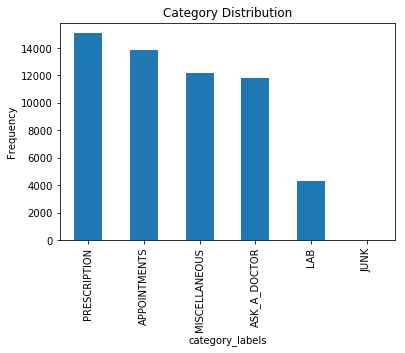

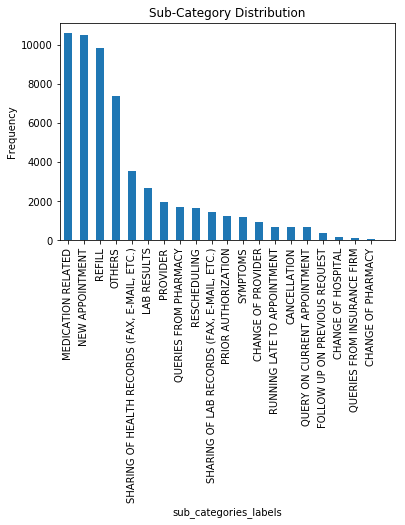

In [14]:
print(dataframe.categories.unique())
print(dataframe.sub_categories.unique())
category_labels = ["PRESCRIPTION","ASK_A_DOCTOR","MISCELLANEOUS","APPOINTMENTS","LAB","JUNK"]
sub_category_labels=["REFILL","MEDICATION RELATED","OTHERS","SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)","QUERY ON CURRENT APPOINTMENT","SYMPTOMS","RESCHEDULING","NEW APPOINTMENT","PROVIDER","SHARING OF LAB RECORDS (FAX, E-MAIL, ETC.)","QUERIES FROM PHARMACY","PRIOR AUTHORIZATION","LAB RESULTS","CANCELLATION","CHANGE OF PROVIDER","RUNNING LATE TO APPOINTMENT","QUERIES FROM INSURANCE FIRM","CHANGE OF HOSPITAL","FOLLOW UP ON PREVIOUS REQUEST","CHANGE OF PHARMACY","JUNK"]

#plot for categories
count_classes = pd.value_counts(dataframe['categories'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Category Distribution")
plt.xticks(range(6), count_classes.index.tolist(),rotation=90)
plt.ylabel("Frequency")
plt.xlabel("category_labels");
plt.show()

#plot for sub-categories
count_classes = pd.value_counts(dataframe['sub_categories'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Sub-Category Distribution")
plt.xticks(range(20), count_classes.index.tolist(),rotation=90)
plt.ylabel("Frequency")
plt.xlabel("sub_categories_labels");
plt.show()

#### Data Pre-processing

In [15]:
#Remove rows having NAN's
dataframe.dropna(how='any',inplace=True)
nan_rows = dataframe[dataframe.isnull().T.any().T]
print(dataframe.isnull().sum(axis=0))

fileid            0
sub_categories    0
categories        0
converse          0
dtype: int64


In [16]:
#remove stopwords
df=dataframe["converse"]
stop = stopwords.words('english')
print(stop)
print(len(df.str.cat(sep=' ').split()))


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

In [17]:
def remove_noise(input_text):
    words = input_text.split() 
    noise_free_words = [word for word in words if word not in stop] 
    noise_free_text = " ".join(noise_free_words) 
    return noise_free_text

In [18]:
dataframe["converse"] = dataframe["converse"].apply(lambda x: remove_noise(x))

In [19]:
print(len(dataframe["converse"].str.cat(sep=' ').split()))

3139066


In [20]:
#To remove multiple spaces
dataframe["converse"] = dataframe["converse"].apply(lambda x: x.strip())


In [21]:
#perform lemmatization and stemming 
lem = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

def stemming(input_text):
    words = input_text.split() 
    stem_words = [porter_stemmer.stem(word) for word in words] 
    stem_free_text = " ".join(stem_words) 
    return stem_free_text

def lemmatization(input_text):
    words = input_text.split() 
    lemmant_words = [lem(word) for word in words if word not in stop] 
    lemmant_free_text = " ".join(lemmant_words) 
    return lemmant_free_text

In [22]:
dataframe["converse"] = dataframe["converse"].apply(lambda x: stemming(x) )

In [23]:
#nf = nf.apply(lambda x: lemmatization(x) )
#print(nf)

#### Word Embedding

In [24]:
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')

Indexing word vectors.
Found 400000 word vectors.
Processing text dataset


In [25]:
nf_conv=dataframe["converse"]
nf_cat=dataframe["categories"]
nf_subcat=dataframe["sub_categories"]

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(nf_conv)
sequences = tokenizer.texts_to_sequences(nf_conv)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


Found 31151 unique tokens.


In [26]:
# One hot encoding of labels
labels_cat=nf_cat.values
labels_subcat=nf_subcat.values
print(labels_cat)
print(labels_subcat)

le = preprocessing.LabelEncoder()
le.fit(labels_cat)
lab_cat=le.transform(labels_cat)
print(lab_cat)

le = preprocessing.LabelEncoder()
le.fit(labels_subcat)
lab_subcat=le.transform(labels_subcat)
print(lab_subcat)

labels_categorical = to_categorical(np.asarray(lab_cat))
labels_subcategorical = to_categorical(np.asarray(lab_subcat))

print(labels_categorical)
print(labels_subcategorical)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels_categorical.shape)
print('Shape of label tensor:', labels_subcategorical.shape)

['PRESCRIPTION' 'ASK_A_DOCTOR' 'ASK_A_DOCTOR' ..., 'MISCELLANEOUS'
 'MISCELLANEOUS' 'MISCELLANEOUS']
['REFILL' 'MEDICATION RELATED' 'MEDICATION RELATED' ..., 'OTHERS'
 'SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)' 'OTHERS']
[5 1 1 ..., 4 4 4]
[15  7  7 ...,  9 18  9]
[[ 0.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
Shape of data tensor: (57244, 1000)
Shape of label tensor: (57244, 6)
Shape of label tensor: (57244, 21)


In [27]:
lab_cat_text=list(le.inverse_transform(lab_cat))
lab_subcat_text=list(le.inverse_transform(lab_subcat))

labels_cat_index = {}  # dictionary mapping label name to numeric id
i=0
for name in (lab_cat_text):
    labels_cat_index[name] = lab_cat[i]
    i=i+1
print(labels_cat_index)

labels_sub_cat_index = {}  # dictionary mapping label name to numeric id
j=0
for name in (lab_subcat_text):
    labels_sub_cat_index[name] = lab_subcat[j]
    j=j+1
print(labels_sub_cat_index)

{'JUNK': 5, 'CHANGE OF HOSPITAL': 1, 'FOLLOW UP ON PREVIOUS REQUEST': 4, 'CANCELLATION': 0, 'CHANGE OF PROVIDER': 3, 'CHANGE OF PHARMACY': 2}
{'REFILL': 15, 'MEDICATION RELATED': 7, 'OTHERS': 9, 'SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)': 18, 'QUERY ON CURRENT APPOINTMENT': 14, 'SYMPTOMS': 20, 'RESCHEDULING': 16, 'NEW APPOINTMENT': 8, 'PROVIDER': 11, 'SHARING OF LAB RECORDS (FAX, E-MAIL, ETC.)': 19, 'QUERIES FROM PHARMACY': 13, 'PRIOR AUTHORIZATION': 10, 'LAB RESULTS': 6, 'CANCELLATION': 0, 'CHANGE OF PROVIDER': 3, 'RUNNING LATE TO APPOINTMENT': 17, 'QUERIES FROM INSURANCE FIRM': 12, 'CHANGE OF HOSPITAL': 1, 'FOLLOW UP ON PREVIOUS REQUEST': 4, 'CHANGE OF PHARMACY': 2, 'JUNK': 5}


In [28]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels_categorical = labels_categorical[indices]
labels_subcategorical = labels_subcategorical[indices]

num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
ycat_train = labels_categorical[:-num_validation_samples]
ysubcat_train = labels_subcategorical[:-num_validation_samples]
x_val = data[-num_validation_samples:]
ycat_val = labels_categorical[-num_validation_samples:]
ysubcat_val = labels_subcategorical[-num_validation_samples:]

print('Preparing embedding matrix.')

Preparing embedding matrix.


In [29]:
# prepare embedding matrix
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
print('Training model.')

Training model.


In [30]:
print(embedding_matrix.shape)

(20000, 100)


#### Build MLP Model for category

In [31]:
MLPmodelcat = Sequential()
MLPmodelcat.add(Embedding(num_words,
                    EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix],
                    # trainable=False
                    ))
MLPmodelcat.add(Lambda(lambda x: tf.reduce_mean(x, axis=1)))
MLPmodelcat.add(Dense(50, activation = 'relu'))
MLPmodelcat.add(Dense(len(labels_cat_index), activation='softmax'))
MLPmodelcat.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         2000000   
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 2,005,356
Trainable params: 2,005,356
Non-trainable params: 0
_________________________________________________________________


In [32]:
from keras import callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
              patience=5, min_lr=0.00001, verbose=1, epsilon=0.001)
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=1, mode='auto')
MLPmodelcat.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [34]:
MLPmodelcat.fit(x_train, ycat_train,
          batch_size=64,
          epochs=20,
          validation_data=(x_val, ycat_val),
         callbacks=[reduce_lr, early_stop])

#### MLP model for subcategory

In [ ]:
MLPmodelsubcat = Sequential()
MLPmodelsubcat.add(Embedding(num_words,
                    EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix],
                    # trainable=False
                    ))
MLPmodelsubcat.add(Lambda(lambda x: tf.reduce_mean(x, axis=1)))
MLPmodelsubcat.add(Dense(5, activation = 'relu'))
MLPmodelsubcat.add(Dense(len(labels_sub_cat_index), activation='softmax'))
MLPmodelsubcat.summary()

In [ ]:
from keras import callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
              patience=5, min_lr=0.00001, verbose=1, epsilon=0.001)
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=1, mode='auto')
MLPmodelsubcat.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [ ]:
MLPmodelsubcat.fit(x_train, ysubcat_train,
         batch_size=64,
         epochs=20,
         validation_data=(x_val, ysubcat_val),
         callbacks=[reduce_lr, early_stop])

In [ ]:
score = MLPmodelcat.evaluate(x_val, ycat_val,verbose=1)
print(score)
score = MLPmodelsubcat.evaluate(x_val, ysubcat_val,verbose=1)
print(score)

In [ ]:
predict_cat=MLPmodelcat.predict_classes(x_val, verbose=1)
predict_subcat=MLPmodelsubcat.predict_classes(x_val, verbose=1)

In [ ]:
def recall(y_true, y_pred):
    i = set(y_true).intersection(y_pred)
    return len(i) / len(y_true)

ycattest=np.argmax(ycat_val,axis=1)
ysubcattest=np.argmax(ysubcat_val,axis=1)

#ycattest = np.asarray(list(map(lambda x: np.argmax(x), ycat_val)))
print(recall(ycattest,predict_cat))

#ysubcattest = np.asarray(list(map(lambda x: np.argmax(x), ysubcat_val)))
print(recall(ysubcattest,predict_subcat))

print(confusion_matrix(predict_cat,ycattest))
print(confusion_matrix(predict_subcat,ysubcattest))

#### Build CNN Model for Category

In [35]:
CNNmodelcat = Sequential()
CNNmodelcat.add(Embedding(num_words,
                    EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix],
                    # trainable=False
                    ))
CNNmodelcat.add(Dropout(0.2))
CNNmodelcat.add(Conv1D(25,3,padding='valid',activation='relu',strides=1))
CNNmodelcat.add(GlobalMaxPooling1D())
CNNmodelcat.add(Dense(250, activation = 'relu'))
CNNmodelcat.add(Dropout(0.2))                
CNNmodelcat.add(Dense(len(labels_cat_index), activation='softmax'))
CNNmodelcat.summary() 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         2000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 998, 25)           7525      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               6500      
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 1506      
Total para

In [ ]:
from keras import callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
              patience=5, min_lr=0.00001, verbose=1, epsilon=0.001)
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=1, mode='auto')
CNNmodelcat.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [ ]:
CNNmodelcat.fit(x_train, ycat_train,
          batch_size=64,
          epochs=20,
          validation_data=(x_val, ycat_val),
         callbacks=[reduce_lr, early_stop])

#### CNN model for subcategory

In [36]:
CNNmodelsubcat = Sequential()
CNNmodelsubcat.add(Embedding(num_words,
                    EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix],
                    # trainable=False
                    ))
CNNmodelsubcat.add(Dropout(0.2))
CNNmodelsubcat.add(Conv1D(25,3,padding='valid',activation='relu',strides=1))
CNNmodelsubcat.add(GlobalMaxPooling1D())
CNNmodelsubcat.add(Dense(250, activation = 'relu'))
CNNmodelsubcat.add(Dropout(0.2))                
CNNmodelsubcat.add(Dense(len(labels_sub_cat_index), activation='softmax'))
CNNmodelsubcat.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 100)         2000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000, 100)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 998, 25)           7525      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 25)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               6500      
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 21)                5271      
Total para

In [ ]:
from keras import callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
              patience=5, min_lr=0.00001, verbose=1, epsilon=0.001)
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=1, mode='auto')
CNNmodelsubcat.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [ ]:
CNNmodelsubcat.fit(x_train, ysubcat_train,
          batch_size=64,
          epochs=20,
          validation_data=(x_val, ysubcat_val),
          callbacks=[reduce_lr, early_stop])

In [ ]:
score = CNNmodelcat.evaluate(x_val, ycat_val,verbose=0)
print(score)
score = CNNmodelsubcat.evaluate(x_val, ysubcat_val,verbose=0)
print(score)

In [ ]:
predict_cat=CNNmodelcat.predict_classes(x_val, verbose=0)
predict_subcat=CNNmodelsubcat.predict_classes(x_val, verbose=0)

In [ ]:
def recall(y_true, y_pred):
    i = set(y_true).intersection(y_pred)
    return len(i) / len(y_true)
print(recall(ycattest,predict_cat))
print(recall(ysubcattest,predict_subcat))

#print(confusion_matrix(ycattest,predict_cat))
#print(confusion_matrix(ysubcattest,predict_subcat))


#### Build RNN Model for Category

In [37]:
RNNmodelcat = Sequential()
RNNmodelcat.add(Embedding(num_words,
                    EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix],
                    # trainable=False
                    ))
#RNNmodelcat.add(LSTM(250, input_shape=(MAX_SEQUENCE_LENGTH, embedding_matrix.shape[1](or may be output label dimension)),return_sequences=False))
RNNmodelcat.add(LSTM(2))
RNNmodelcat.add(Dense(len(labels_cat_index), activation='softmax'))
RNNmodelcat.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 100)         2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 824       
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 18        
Total params: 2,000,842
Trainable params: 2,000,842
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras import callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
              patience=5, min_lr=0.00001, verbose=1, epsilon=0.001)
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=1, mode='auto')
RNNmodelcat.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [ ]:
RNNmodelcat.fit(x_train, ycat_train,
          batch_size=64,
          epochs=20,
          validation_data=(x_val, ycat_val),
          callbacks=[reduce_lr, early_stop])

#### RNN model for subcategory

In [ ]:
RNNmodelsubcat = Sequential()
RNNmodelsubcat.add(Embedding(num_words,
                    EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH,
                    weights=[embedding_matrix],
                    # trainable=False
                    ))
#RNNmodelcat.add(LSTM(250, input_shape=(MAX_SEQUENCE_LENGTH, embedding_matrix.shape[1](or may be output label dimension)),return_sequences=False))
RNNmodelsubcat.add(LSTM(2))
RNNmodelsubcat.add(Dense(len(labels_sub_cat_index), activation='softmax'))
RNNmodelsubcat.summary()

In [ ]:
from keras import callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
              patience=5, min_lr=0.00001, verbose=1, epsilon=0.001)
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=1, mode='auto')
RNNmodelsubcat.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [ ]:
RNNmodelsubcat.fit(x_train, ysubcat_train,
          batch_size=64,
          epochs=20,
          validation_data=(x_val, ysubcat_val),
          callbacks=[reduce_lr, early_stop])

In [ ]:
score = RNNmodelcat.evaluate(x_val, ycat_val,verbose=1)
print(score)
score = RNNmodelsubcat.evaluate(x_val, ysubcat_val,verbose=1)
print(score)

In [ ]:
predict_cat=RNNmodelcat.predict_classes(x_val, verbose=1)
predict_subcat=RNNmodelsubcat.predict_classes(x_val, verbose=1)

In [ ]:
def recall(y_true, y_pred):
    i = set(y_true).intersection(y_pred)
    return len(i) / len(y_true)

print(recall(ycattest,predict_cat))

print(recall(ysubcattest,predict_subcat))
print(confusion_matrix(predict_cat,ycattest))
print(confusion_matrix(predict_subcat,ysubcattest))